# Práctica

Se utilizará el <i>framework</i> de __Pytorch__. 

## 1. Entorno Crude Scheduler

### 1.1. Establecer el entorno

En primer lugar cargaremos la librería __gym__ e inicializaremos el entorno.

In [46]:
if not ('isColab' in locals()):
    if 'google.colab' in str(get_ipython()):
        print('Running on CoLab')
        !pip install gymnasium
        !wget https://github.com/BaltiBoix/Scheduling/raw/master/tankEnvV2.py
        isColab = True
    else:
        print('Not running on CoLab')

Not running on CoLab


In [47]:
import gymnasium as gym
from gymnasium.spaces import flatten as flat
import torch
import numpy as np
import json
import matplotlib.pyplot as plt
from copy import deepcopy, copy
from collections import namedtuple, deque, OrderedDict
import os
import IPython.display
import sklearn
import sklearn.pipeline
from sklearn.kernel_approximation import RBFSampler

import tankEnvV2

env = gym.envs.make('crudeTanksEnv-v2')

In [48]:
print('Is torch cuda available?: {}'.format(torch.cuda.is_available()))

Is torch cuda available?: True


### Descripción del entorno

In [49]:
env.spec

EnvSpec(id='crudeTanksEnv-v2', entry_point=<class 'tankEnvV2.crudeTanksEnv'>, reward_threshold=700, nondeterministic=False, max_episode_steps=720, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='crudeTanksEnv', version=2)

In [50]:
def flatFixData(env, t=0, nCargos=6):
    n = nCargos - len(env.S.cargo.sched.keys())
    if n > 0:
        fSched = n*12*[0.0]
    else:
        fSched = []
    for k, v in env.S.cargo.sched.items():
        fSched += [k-t] + [v.vol] + v.toDict()['comp']
    fAssay = env.S.unit.assay.reshape(-1)
    return np.concatenate((fSched, fAssay, env.S.unit.volCutMax), axis=-1)

In [51]:
state0, data = env.reset()
state0 = np.concatenate((flatFixData(env, env.S.t), data['actionAvail'], flat(env.observation_space, state0)), axis=-1)
n_inputs = state0.shape[0]

In [52]:
crudeNames = np.array(['ARABIA LIGERO', 'BONNY LIGERO', 'BRASS RIVER', 'BRENT', 'CPC BLEND', 'DALIA', 
                       'PAZFLOR', 'SARIR', 'SIRTICA', 'ZAFIRO BLEND'])

assay = np.array(
    [[0.2083, 0.2503, 0.3046, 0.286 , 0.3979, 0.0596, 0.0843, 0.2039, 0.3133, 0.1962],
    [0.1639, 0.1502, 0.17  , 0.1457, 0.187 , 0.1094, 0.0978, 0.1249, 0.1546, 0.1427],
    [0.22  , 0.3191, 0.289 , 0.2297, 0.2281, 0.253 , 0.2845, 0.232, 0.2341, 0.2863],
    [0.2209, 0.2094, 0.1862, 0.2114, 0.1351, 0.3135, 0.2804, 0.2541, 0.1819, 0.2339],
    [0.1869, 0.071 , 0.0502, 0.1272, 0.0519, 0.2645, 0.253 , 0.1851, 0.1161, 0.1409]]
)
        
unitVolCutMax = np.array([0.25, 0.2, 0.4, 0.3, 0.2])

## Actor-Critic method


Basado en el ejemplo de pytorch:  

https://medium.com/geekculture/actor-critic-implementing-actor-critic-methods-82efb998c273

In [53]:
class AC_actor(torch.nn.Module):

    def __init__(self, env, n_inputs, learning_rate=1e-3, device='cpu'):
        """
        Actor ANN
        """
        super(AC_actor, self).__init__()

        self.n_inputs = n_inputs
        self.n_outputs = env.action_space.n
        self.learning_rate = learning_rate

        if torch.cuda.is_available() and device=='cuda':
            self.device = 'cuda'
        else:
            self.device = 'cpu'

        self.learning_rate = learning_rate

        # AC Actor
        self.actor = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512, bias=True),
            torch.nn.LayerNorm(512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256, bias=True),
            torch.nn.ReLU(),       
            torch.nn.Linear(256, 256, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128, bias=True),
            torch.nn.ReLU(),       
            torch.nn.Linear(128, self.n_outputs, bias=True),
            torch.nn.Softmax(dim=-1)
        )

        if self.device == 'cuda':
            self.actor.cuda()
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        # self.lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='max', 
        #                                                            patience=200, factor=0.5, min_lr=0.0001, verbose=True)

        # self.init_weights()

    #Obtención de las probabilidades de las posibles acciones
    def get_action(self, state):
        state_t = torch.FloatTensor(state).to(device=self.device)
        
        return torch.distributions.Categorical(self.actor(state_t))

    def init_weights(self):
        self.actor.apply(self.init_weights_)

    def init_weights_(self, m):
        if isinstance(m, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(pow(5., -0.5))

In [54]:
class AC_critic(torch.nn.Module):

    def __init__(self, env, n_inputs, learning_rate=1e-3, device='cpu'):
        """
        Critic ANN
        """
        super(AC_critic, self).__init__()

        self.n_inputs = n_inputs
        self.learning_rate = learning_rate

        if torch.cuda.is_available() and device=='cuda':
            self.device = 'cuda'
        else:
            self.device = 'cpu'

        self.learning_rate = learning_rate

        # AC Critic
        self.critic = torch.nn.Sequential(
            torch.nn.Linear(self.n_inputs, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512, bias=True),
            torch.nn.LayerNorm(512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 1, bias=True)
        )

        if self.device == 'cuda':
            self.critic.cuda()
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        # self.lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='max', 
        #                                                            patience=200, factor=0.5, min_lr=0.00001)
    
    def get_val(self, state):
        state_t = torch.FloatTensor(state).to(device=self.device)
        return self.critic(state_t)


### Definición del agente


In [55]:
class ACAgent:

    def __init__(self, env, assay, unitVolCutMax, seed, dnnet_actor, dnnet_critic, nblock=100):
        """
        Params
        ======
        env: entorno
        dnnetwork: clase con la red neuronal diseñada
        nblock: bloque de los X últimos episodios de los que se calculará la media de recompensa
        reward_threshold: umbral de recompensa definido en el entorno
        """
        self.env = env
        self.assay = assay
        self.unitVolCutMax = unitVolCutMax
        self.seed = seed
        self.dnnet_actor = dnnet_actor
        self.dnnet_critic = dnnet_critic
        self.device = dnnet_actor.device
        self.nblock = nblock
        self.reward_threshold = env.spec.reward_threshold
        self.initialize()

    def initialize(self):
        self.losses = []
        self.update_loss = []
        self.training_rewards = []
        self.mean_training_rewards = []
    ######

    ## Entrenamiento
    def train(self, gamma=0.99, max_episodes=2000):
        self.gamma = gamma

        episode = 0
        self.mean_rewards = -1000.0
        self.maxRewards = 0.0
        training = True
        epsilon_max = 0.25
        epsilon_min = 0.00
        epsilon = epsilon_max
        print("Training...")
        while training:
            state, data = self.env.reset(seed=self.seed, assay=self.assay, unitVolCutMax=self.unitVolCutMax)
            actionAvail = data['actionAvail']
            state0 = np.concatenate((flatFixData(self.env), actionAvail, flat(self.env.observation_space, state)), axis=-1)
            episode_rewards = []
            gamedone = False
            t = 1
            I = 1
            while gamedone == False:
                Prob = self.dnnet_actor.get_action(state0)
                action = Prob.sample()
                
                val = self.dnnet_critic.get_val(state0)
                
                prob_log = Prob.log_prob(action)
                
                new_state, reward, gamedone, _, info = self.env.step(action)
                actionAvail = info['actionAvail']
                new_state = np.concatenate((flatFixData(self.env, self.env.S.t), actionAvail, flat(self.env.observation_space, new_state)), axis=-1)
                
                # Almacenamos experiencias que se van obteniendo en este episodio
                episode_rewards.append(reward)
                
                reward_t = torch.tensor([reward], device=self.device, dtype=torch.float)
                new_val = self.dnnet_critic.get_val(new_state)
                #if terminal state, next state val is 0
                if gamedone:
                    new_val = torch.tensor([0], device=self.device, dtype=torch.float)
                    #if t < 700:
                    #    print(action, actionAvail)
                
                #calculate value function loss with MSE
                advantage = reward_t + self.gamma * new_val - val
                loss_critic = advantage.square()
                loss_critic *= I
                
                #calculate policy loss
                loss_actor = -prob_log * advantage.detach()
                loss_actor *= I
                
#                 if t % 100 == 0:
#                     print(cProb.log_prob(cAction), d1Prob.log_prob(d1Action), d2Prob.log_prob(d2Action))
                
                #Backpropagate policy
                self.dnnet_actor.optimizer.zero_grad()
                loss_actor.backward()
                torch.nn.utils.clip_grad_norm_(self.dnnet_actor.parameters(), 10.0) 

                #Backpropagate value
                self.dnnet_critic.optimizer.zero_grad()
                loss_critic.backward()
                torch.nn.utils.clip_grad_norm_(self.dnnet_critic.parameters(), 10.0) 

                nActor, nCritic = self.norm2()
                if t > 1:
                    nActorMean = (nActorMean*t+nActor)/(t+1)
                    nCriticMean = (nCriticMean*t+nCritic)/(t+1)                    
                else:
                    nActorMean = nActor
                    nCriticMean = nCritic
                
                self.dnnet_actor.optimizer.step()
                # self.dnnet_actor.lr_sched.step(self.mean_rewards)

                self.dnnet_critic.optimizer.step()
                # self.dnnet_critic.lr_sched.step(self.mean_rewards)

                state0 = deepcopy(new_state)
                I *= self.gamma
                t += 1
                

            episode += 1

            self.training_rewards.append(sum(episode_rewards)) # guardamos las recompensas obtenidas
            self.mean_rewards = np.mean(self.training_rewards[-self.nblock:])
            self.mean_training_rewards.append(self.mean_rewards)

            if self.training_rewards[-1] > self.maxRewards:
                self.maxRewards = self.training_rewards[-1]
                self.maxS = deepcopy(env.S)
            
            # Comprobamos que todavía quedan episodios
            if episode >= max_episodes:
                training = False
                print('\nEpisode limit reached.')
                break

            epsilon = max(epsilon*0.99, epsilon_min)

            if episode > 100 and episode % 100 == 0:
                self.plot_rewards()

            print("\rEpisode {:3d} Mean Rewards {:.2f} Last Reward {:.2f} "
                "nActor {:.3f} nCritic {:.3f}\t\t".format(
                episode, self.mean_rewards, np.mean(self.training_rewards[-1]), 
                nActorMean, nCriticMean), end="")

            # Termina el juego si la media de recompensas ha llegado al umbral fijado para este juego
            if self.mean_rewards >= self.reward_threshold and episode > self.nblock:
                training = False
                print('\nEnvironment solved in {} episodes!'.format(
                    episode))
                break

    def plot_rewards(self):
       
        IPython.display.clear_output(wait=True)

        plt.figure(figsize=(12,8))
        plt.plot(self.training_rewards, label='Rewards')
        plt.plot(self.mean_training_rewards, label='Mean Rewards')
        plt.axhline(self.env.spec.reward_threshold, color='r', label="Reward threshold")
        plt.xlabel('Episodes')
        plt.ylabel('Rewards')
        plt.legend(loc="upper left")
        plt.grid()
        plt.show()

    def norm2(self):
        norm = lambda parameters : torch.norm(torch.stack([torch.norm(p.grad.detach(), 2) for p in parameters]), 2)
        pActor = self.dnnet_actor.parameters()
        pCritic = self.dnnet_critic.parameters()
        return norm(pActor), norm(pCritic)
        

### Entrenamiento


In [56]:
lr_actor = 1.E-5     #Velocidad de aprendizaje   0.005
lr_critic = 5.E-4    #Velocidad de aprendizaje   0.005
GAMMA = 0.99         #Valor gamma de la ecuación de Bellman
NBLOCK = 100         #Número de steps para rellenar el buffer
MAX_EPISODES = 5000  #Número máximo de episodios (el agente debe aprender antes de llegar a este valor)

In [57]:
ACa = AC_actor(env, n_inputs, learning_rate=lr_actor, device='cuda')

In [58]:
ACc = AC_critic(env, n_inputs, learning_rate=lr_critic, device='cuda')

In [59]:
AC_agent = ACAgent(env, assay, unitVolCutMax, 200560, ACa, ACc, NBLOCK)

In [60]:
%%time

AC_agent.train(gamma=GAMMA, max_episodes=MAX_EPISODES)

Training...
Episode  23 Mean Rewards 92.16 Last Reward 155.70nActor 0.780 nCritic 0.180		

KeyboardInterrupt: 

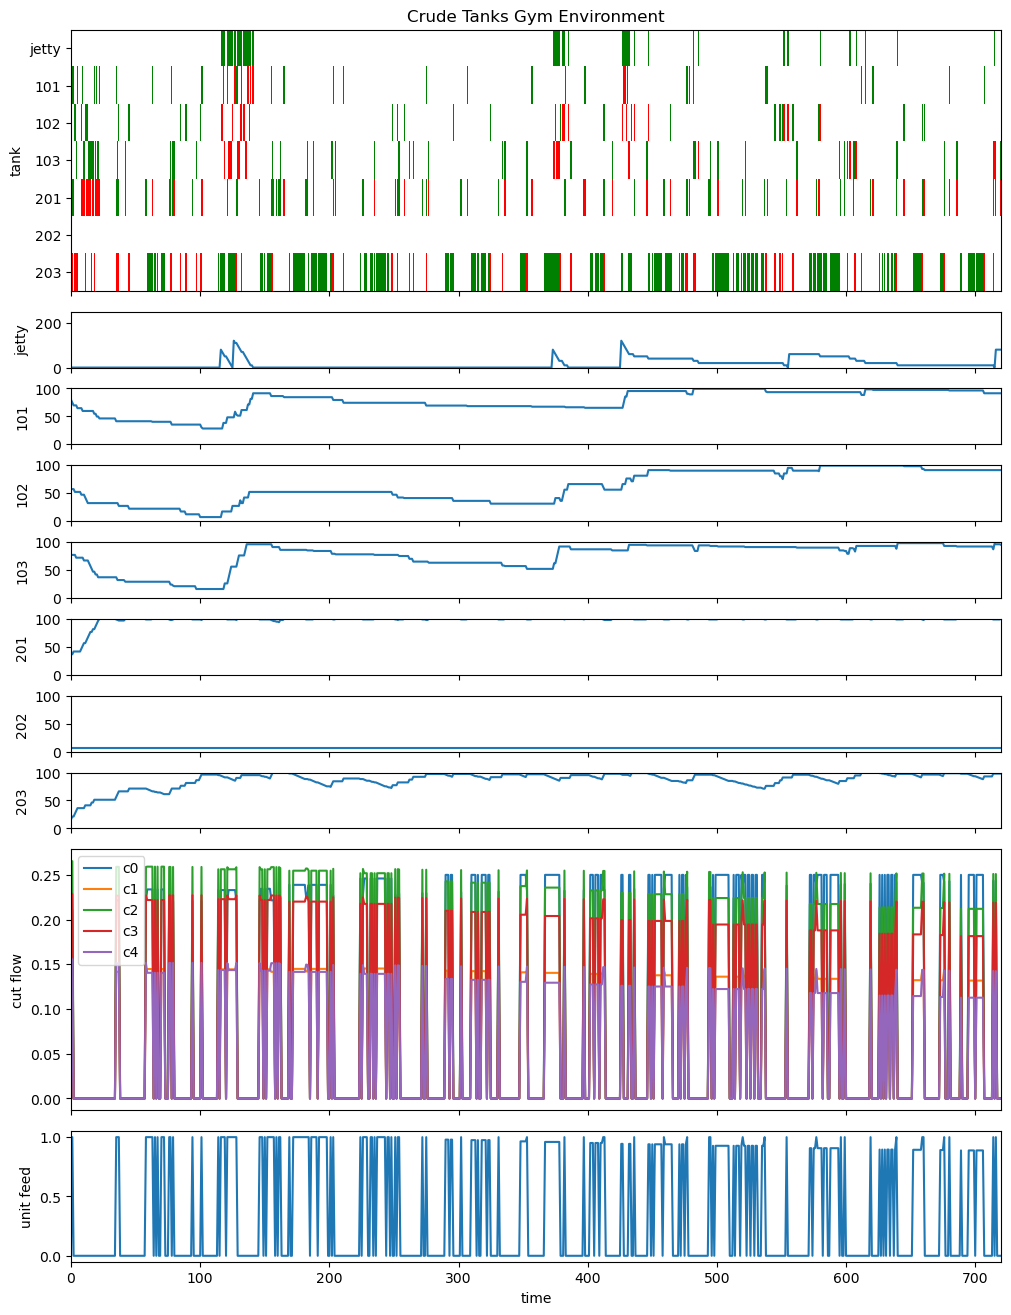

In [61]:
AC_agent.maxS.render()

In [62]:
AC_agent.maxS.prodsLog[300]

KeyError: 300

In [ ]:
AC_agent.plot_rewards()

In [ ]:
myfile = 'agentACDT_Trained_Model.pth'
if os.path.isfile(myfile):
    os.remove(myfile)
torch.save(ACa.state_dict(), myfile)

In [ ]:
%%time

env = gym.envs.make("crudeTanksEnv-v2")

AC = AC_actor(env, n_inputs, learning_rate=0.005, device='cuda')
AC.load_state_dict(torch.load(myfile))

state0, data = self.env.reset(seed=self.seed, assay=self.assay, unitVolCutMax=self.unitVolCutMax)
actionAvail = data['actionAvail']
state0 = np.concatenate((flatFixData(env), actionAvail, flat(env.observation_space, state0)), axis=-1)
done = False
episode_reward = 0
n = 0
action_list = []
while not done:
    Prob = self.dnnet_actor.get_action(state0)
    action = Prob.sample()
    new_state, reward, gamedone, _, info = self.env.step(action)
    actionAvail = info['actionAvail']
    new_state = np.concatenate((flatFixData(env, env.S.t), actionAvail, flat(env.observation_space, new_state)), axis=-1)
    episode_reward += reward
    n += 1
    state0 = deepcopy(new_state)
    if n >= env.spec.max_episode_steps:
        done = True

print('n: {:4d}   reward: {:4.2f}'.format(n, episode_reward))
env.render()
print('\n')

In [ ]:
list(AC.parameters())

In [ ]:
%%time

env = gym.envs.make("crudeTanksEnv-v0")

AC = AC_actor(env, 512, learning_rate=0.005, device='cuda')
AC.load_state_dict(torch.load(myfile))

reward_list = []
n_list = []
for n_episodes in range(20):
    state0 = flat(env.observation_space, env.reset()[0])
    done = False
    episode_reward = 0
    n = 0
    action_list = []
    while not done:
        cProb, d1Prob, d2Prob = AC.get_action(state0)
        cAction = cProb.sample()
        d1Action = d1Prob.sample()
        d2Action = d2Prob.sample()
        action = OrderedDict({'farmTanks': np.array([d1Action.item(), d2Action.item()]),
                              'unitFeed': np.array([cAction.item()])})
        state, reward, done, _, _ = env.step(action)
        state = flat(env.observation_space, state)
        episode_reward += reward
        n += 1
        state0 = deepcopy(state)
        if n >= env.spec.max_episode_steps:
            done = True

    print('{:2d} n: {:4d}   reward: {:4.2f}'.format(n_episodes+1, n, episode_reward))
    reward_list.append(episode_reward)
print('\n')

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))

fig.suptitle('Recompensa de 20 partidas con el modelo ajustado')

ax.plot(reward_list)
ax.axhline(y=env.spec.reward_threshold, color='r', linestyle='-')
ax.set_xlabel('suma de recompensas de cada partida')
ax.set_xticks(range(20))
ax.grid()

plt.show()